## Multiple Shooting methods for ODEs

In [209]:
import torchdyn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdyn.numerics import Euler, RungeKutta4, Tsitouras45, DormandPrince45, MSZero
from torchdyn.numerics import odeint, odeint_mshooting, Lorenz

import torchdiffeq
import time 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
x0 = torch.randn(8, 3) + 15
t_span = torch.linspace(0, 3, 2000)
sys = Lorenz()

In [240]:
t0 = time.time()
t_eval, accurate_sol = odeint(sys, x0, t_span, solver='dopri5', atol=1e-8, rtol=1e-8)
accurate_sol_time = time.time() - t0

t0 = time.time()
t_eval, base_sol = odeint(sys, x0, t_span, solver='euler')
base_sol_time = time.time() - t0

t0 = time.time()
t_eval, rk4_sol = odeint(sys, x0, t_span, solver='rk4')
rk4_sol_time = time.time() - t0

t0 = time.time()
t_eval, dp5_low_sol = odeint(sys, x0, t_span, solver='dopri5', atol=1e-3, rtol=1e-3)
dp5_low_time = time.time() - t0

t0 = time.time()
t_eval, ms_sol = odeint_mshooting(sys, x0, t_span, solver='mszero', fine_steps=2, maxiter=4)
ms_sol_time = time.time() - t0

In [248]:
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

Text(0.5, 1.0, 'Wall-clock sol time')

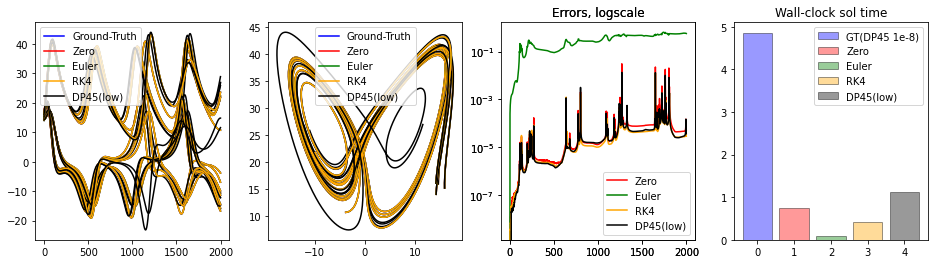

In [272]:
err_zero = smape(ms_sol, accurate_sol).mean(1).sum(1)
err_base = smape(base_sol, accurate_sol).mean(1).sum(1)
err_rk4 = smape(rk4_sol, accurate_sol).mean(1).sum(1)
err_dp5 = smape(dp5_low_sol, accurate_sol).mean(1).sum(1)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,4,1)
for i in range(4):
    for j in range(3):
        ax.plot(accurate_sol[:,i,j], c='b')
        ax.plot(ms_sol[1:,i,j], c='r')
        ax.plot(rk4_sol[:,i,j], c='green')        
        ax.plot(dp5_low_sol[:,i,j], c='orange')
        ax.plot(base_sol[:,i,j], c='black')
        ax.legend(['Ground-Truth', 'Zero', 'Euler', 'RK4', 'DP45(low)'])
        
ax = fig.add_subplot(1,4,2)
for i in range(4):
    ax.plot(accurate_sol[:,i,0], accurate_sol[:,i,2], c='blue')
    ax.plot(ms_sol[:,i,0], ms_sol[:,i,2], c='r')
    ax.plot(rk4_sol[:,i,0], rk4_sol[:,i,2], c='g')
    ax.plot(dp5_low_sol[:,i,0], dp5_low_sol[:,i,2], c='orange')
    ax.plot(base_sol[:,i,0], base_sol[:,i,2], c='black')
    ax.legend(['Ground-Truth', 'Zero', 'Euler', 'RK4', 'DP45(low)'])

ax = fig.add_subplot(1,4,3)
ax.plot(err_zero, c='r')
ax.plot(err_base, c='black')
ax.plot(err_rk4, c='green')
ax.plot(err_dp5, c='orange')
ax.set_yscale('log')
ax.legend(['Ground-Truth', 'Zero', 'Euler', 'RK4', 'DP45(low)'])
ax.set_title('Errors, logscale')

ax = fig.add_subplot(1,4,3)
ax.plot(err_zero, c='r')
ax.plot(err_base, c='green')
ax.plot(err_rk4, c='orange')
ax.plot(err_dp5, c='black')
ax.set_yscale('log')
ax.legend(['Zero', 'Euler', 'RK4', 'DP45(low)'])
ax.set_title('Errors, logscale')

times = [accurate_sol_time, ms_sol_time, base_sol_time, rk4_sol_time, dp5_low_time]
ax = fig.add_subplot(1,4,4)
colors = ['b', 'r', 'g', 'orange', 'black']
for k in range(5):
    barlist = ax.bar(0 + k, times[k:k+1], color=colors[k], alpha=0.4, edgecolor='black')
ax.legend(['GT(DP45 1e-8)', 'Zero', 'Euler', 'RK4', 'DP45(low)'])
ax.set_title('Wall-clock sol time')